In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

# Download the flowers dataset

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# 해당 url을 압축 해제해서 flower_photos라는 파일로 불러오기
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [3]:
# 이미지의 개수
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


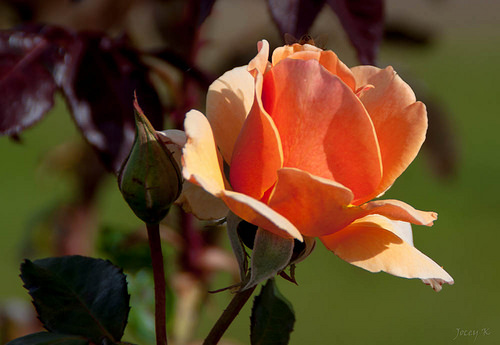

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# Load using tf.keras.preprocessing

In [6]:
# parameter 설정
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# 80%를 train dataset으로 이용
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
# 20%를 validation dataset으로 이용
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# class 종류 확인
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data

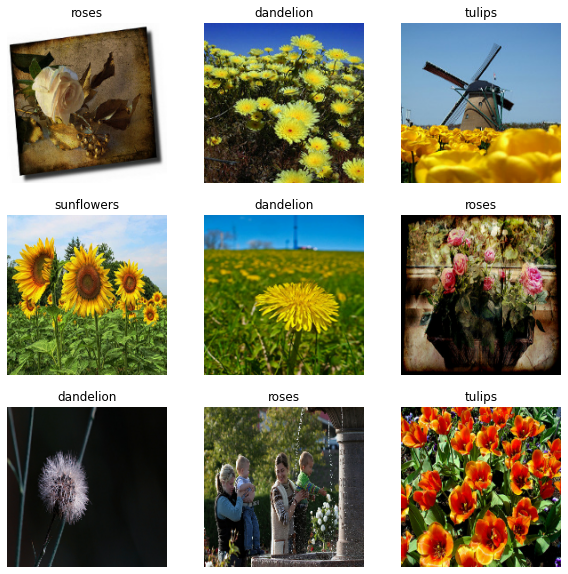

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
# 배치사이즈 확인
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Standardize the data

In [15]:
# 0~1 사이의 값으로 표준화
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
# train_ds에 표준화 적용
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


# Configure the dataset for performance

In [17]:
# prefetch: 다음 배치 미리 대기시켜 학습속도 향상
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train a model

In [18]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [21]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 119s 1s/step - loss: 1.2719 - accuracy: 0.4632 - val_loss: 1.1323 - val_accuracy: 0.5272
Epoch 2/3
92/92 [==============================] - 113s 1s/step - loss: 1.0273 - accuracy: 0.5872 - val_loss: 0.9972 - val_accuracy: 0.6240
Epoch 3/3
92/92 [==============================] - 113s 1s/step - loss: 0.8594 - accuracy: 0.6689 - val_loss: 0.9809 - val_accuracy: 0.6213


# Using tf.data for finer control

In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/503770507_f397245a6a.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/5033866477_a77cccba49_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/6250363717_17732e992e_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/3062794421_295f8c2c4e.jpg'
b'/root/.keras/datasets/flower_photos/tulips/13542672763_20c3cb9272.jpg'


In [30]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [31]:
# valid_ds로 20% 할당 후 나머지 train_ds로 할당
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [32]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [33]:
def get_label(file_path):
  #os.path.sep: os별 파일 경로 구분 문자
  parts = tf.strings.split(file_path, os.path.sep)
  # class_names를 통해 해당하는 라벨에 대해서만 True로 원핫인코딩 형태로 저장
  one_hot = parts[-2] == class_names
  # True에 해당하는 인덱스 리턴
  return tf.argmax(one_hot)

In [34]:
def decode_img(img):
  # jpeg 이미지를 uint8 텐서로 디코딩
  img = tf.io.decode_jpeg(img, channels=3)
  # resize
  return tf.image.resize(img, [img_height, img_width])

In [35]:
# img, label 형태로 리턴
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [36]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


# Configure datset for performance

In [42]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

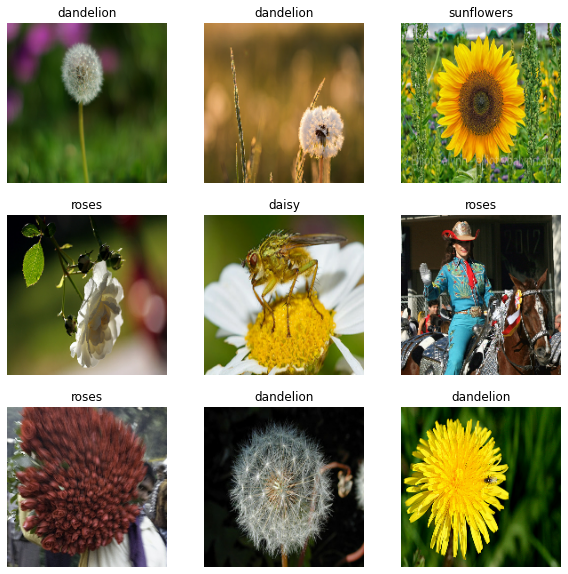

In [43]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# Continue training the model

In [44]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 124s 1s/step - loss: 0.7622 - accuracy: 0.7146 - val_loss: 0.7020 - val_accuracy: 0.7302
Epoch 2/3
92/92 [==============================] - 122s 1s/step - loss: 0.5424 - accuracy: 0.8082 - val_loss: 0.7256 - val_accuracy: 0.7221
Epoch 3/3
92/92 [==============================] - 120s 1s/step - loss: 0.3388 - accuracy: 0.8784 - val_loss: 0.7869 - val_accuracy: 0.7302


# Using Tensorflow Datstets

In [45]:
# train 80%, val 10%, test 10%
# with_info를 설정 시 데이터셋에 대한 정보를 불러온다. metadata에 저장
# as_supervised: True일 경우 tuple 형태로, False일 경우 dict 형태로 img, label을 불러온다
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [46]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


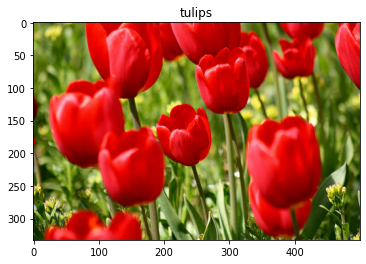

In [47]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [48]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)